In [88]:
import glob
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [63]:
datadir = 'F:/Documents/WETO Incubator/OpenFAST/VolturnUS15MW'
md_out_files = glob.glob(os.path.join(datadir, '*_500m.MD.Line*.out'))
numlines = len(md_out_files)
numnodes = 50

In [64]:
out_dfs = []
for out_file in md_out_files:
    linenum = out_file[-5] # only valid for single-digit lines with filenames ending with '.out'
    out_df = pd.read_csv(out_file, sep='\s+', skiprows=[1], na_values=['***************'])
    out_df.columns = out_df.columns.str.replace('^Node', f'L{linenum}Node', regex=True)
    out_df.columns = out_df.columns.str.replace('^Seg', f'L{linenum}Seg', regex=True)
    out_dfs.append(out_df)


TODO: 
* Find a way to remove duplicate Time columns
* Remove transient (first 90 seconds) from data

In [65]:
mdout = pd.concat(out_dfs, axis=1)

In [67]:
maxs = {
    'Depth': np.zeros(numnodes+1),
    'Footprint Length': np.zeros(numnodes+1),
    'Footprint Width': np.zeros(numnodes+1),
}
for l in range(numlines):
   maxs[f'L{l+1} Max Hor Disp'] = np.zeros(numnodes+1)
   maxs[f'L{l+1} Max Vert Disp'] = np.zeros(numnodes+1)
   maxs[f'L{l+1} Max Disp Mag'] = np.zeros(numnodes+1)
   maxs[f'L{l+1} Max Tension'] = np.zeros(numnodes+1)

for n in range(numnodes+1):
    # for loop cycling through lines, then either (1) finding overall max at that node across all lines, or (2) recording the max for each line
    max_depth = np.abs(mdout.loc[0, f'L1Node{n}pz'])
    fp_length = np.abs(mdout.loc[n, f'L1Node{n}px'] - mdout.loc[n, f'L2Node{n}px'])
    fp_width = np.abs(mdout.loc[n, f'L2Node{n}py'] - mdout.loc[n, f'L3Node{n}py'])
    for l in range(numlines):
      if n == 0:
          max_ten = np.nan
      else:
        max_ten = mdout[f'L{l+1}Seg{n}Ten'].max()
      hor_disp = np.sqrt(
          (mdout[f'L{l+1}Node{n}px'] - mdout.loc[0, f'L{l+1}Node{n}px'])**2
        + (mdout[f'L{l+1}Node{n}py'] - mdout.loc[0, f'L{l+1}Node{n}py'])**2
      )
      vert_disp = mdout[f'L{l+1}Node{n}pz'] - mdout[f'L{l+1}Node{n}pz'][0]
      mag_disp = np.sqrt(
          (mdout[f'L{l+1}Node{n}px'] - mdout.loc[0, f'L{l+1}Node{n}px'])**2
        + (mdout[f'L{l+1}Node{n}py'] - mdout.loc[0, f'L{l+1}Node{n}py'])**2
        + (mdout[f'L{l+1}Node{n}pz'] - mdout.loc[0, f'L{l+1}Node{n}pz'])**2
      )
      max_hor_disp = hor_disp.max()
      max_vert_disp = vert_disp.max()
      max_mag_disp = mag_disp.max()

      # maxs['Partition Node'][n] = int(n)
      maxs[f'L{l+1} Max Disp Mag'][n] = max_mag_disp
      maxs[f'L{l+1} Max Hor Disp'][n] = max_hor_disp
      maxs[f'L{l+1} Max Vert Disp'][n] = max_vert_disp
      maxs[f'L{l+1} Max Tension'][n] = max_ten
    maxs['Depth'][n] = max_depth
    maxs['Footprint Length'][n] = fp_length
    maxs['Footprint Width'][n] = fp_width


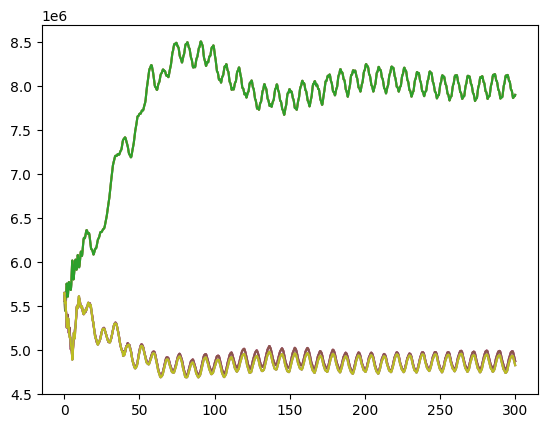

In [103]:
plt.plot(mdout['Time'], mdout['L1Seg50Ten'], label='Line 1')
plt.plot(mdout['Time'], mdout['L2Seg50Ten'], label='Line 2')
plt.plot(mdout['Time'], mdout['L3Seg50Ten'], label='Line 3')

In [68]:
node_maxs = pd.DataFrame(data=maxs)

In [69]:
node_maxs

,Depth,Footprint Length,Footprint Width,L1 Max Hor Disp,L1 Max Vert Disp,L1 Max Disp Mag,L1 Max Tension,L2 Max Hor Disp,L2 Max Vert Disp,L2 Max Disp Mag,L2 Max Tension,L3 Max Hor Disp,L3 Max Vert Disp,L3 Max Disp Mag,L3 Max Tension
0,500.000000,3009.738000,3475.346000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,NaN
1,500.005840,2945.295880,3400.934600,0.031378,0.000010,0.031378,5725394.2,1.032328,0.000000,1.032328,2960070.7,1.009265,0.000000,1.009265,2960070.7
2,500.005850,2880.853660,3326.523200,0.062151,0.000000,0.062151,5725327.8,2.050063,0.000000,2.050063,2959957.5,2.000450,0.000000,2.000450,2959957.5
3,500.005850,2816.411550,3252.111800,0.092120,0.000000,0.092120,5725196.2,3.047951,0.000000,3.047951,2959731.5,2.968485,0.000000,2.968485,2959731.5
4,500.005850,2751.969340,3177.700400,0.121317,0.000000,0.121317,5725001.1,4.035831,0.000000,4.035831,2959393.6,3.929310,0.000000,3.929310,2959393.6
5,500.005850,2687.527240,3103.289000,0.150052,0.000000,0.150052,5724745.2,5.030122,0.000000,5.030122,2958945.3,4.904144,0.000000,4.904144,2958945.3
6,500.005850,2623.085260,3028.877800,0.178220,0.000000,0.178220,5724431.8,6.029401,0.000000,6.029401,2958388.4,5.886055,0.000000,5.886055,2958388.4
7,500.005850,2558.643200,2954.466600,0.205470,0.000000,0.205470,5724064.8,7.021360,0.000000,7.021360,2957725.1,6.858922,0.000000,6.858922,2957725.1
8,500.005850,2494.201360,2880.055400,0.231765,0.000000,0.231765,5723654.3,7.998902,0.000000,7.998902,2956981.4,7.816508,0.000000,7.816508,2956981.4
9,500.005850,2429.759450,2805.644400,0.257517,0.000000,0.257517,5723228.6,8.962034,0.000000,8.962034,2956149.6,8.760729,0.000000,8.760729,2956149.6


In [78]:
partition_maxs = maxs = {
    'Max Hor Disp': np.zeros(numnodes),
    'Max Vert Disp': np.zeros(numnodes),
    'Max Disp Mag': np.zeros(numnodes),
    'Max Tension': np.zeros(numnodes),
    'Physical Depth': np.zeros(numnodes),
    'Footprint Length': np.zeros(numnodes),
    'Footprint Width': np.zeros(numnodes),
    'Max Scaling': np.zeros(numnodes),
    'Scaled Hor Disp': np.zeros(numnodes),
    'Scaled Vert Disp': np.zeros(numnodes),
    'Scaled Disp Mag': np.zeros(numnodes),
    'Scaled Tension': np.zeros(numnodes),
}
partition_nodes = np.zeros(numnodes)

In [79]:
node_maxs.filter(regex='Max Hor Disp$').max().max()

47.46527101319133

In [80]:
def calc_max_scaling(basin_depth, basin_length, basin_width, full_depth, full_fp_length, full_fp_width):
    depth_scaling = full_depth / basin_depth
    fp_length_scaling = full_fp_length / basin_length
    fp_width_scaling = full_fp_width / basin_width
    return np.min([depth_scaling, fp_length_scaling, fp_width_scaling])

def scale_length(full_scale, scale_factor):
    return full_scale / scale_factor

def scale_force(full_scale, scale_factor):
    return full_scale / scale_factor ** 3

In [81]:
# UMaine basin dimensions (in meters)
w2_length = 30
w2_width = 9
w2_depth = 4.5

In [84]:

for n in range(1, numnodes+1):
    max_phys_depth = node_maxs.loc[numnodes-n:, 'Depth'].max()
    max_fp_length = node_maxs.loc[numnodes-n:, 'Footprint Length'].max()
    max_fp_width = node_maxs.loc[numnodes-n:, 'Footprint Width'].max()
    max_hor_disp = node_maxs.filter(regex='Max Hor Disp$').loc[numnodes-n:, :].max().max()
    max_vert_disp = node_maxs.filter(regex='Max Vert Disp$').loc[numnodes-n:, :].max().max()
    max_mag_disp = node_maxs.filter(regex='Max Disp Mag$').loc[numnodes-n:, :].max().max()
    max_seg_ten = node_maxs.filter(regex='Max Tension$').loc[numnodes-n:, :].max().max()
    max_scaling = calc_max_scaling(w2_depth, w2_length, w2_width,
                                   max_phys_depth, max_fp_length, max_fp_width)
    scaled_hor_disp = scale_length(max_hor_disp, max_scaling)
    scaled_vert_disp = scale_length(max_vert_disp, max_scaling)
    scaled_mag_disp = scale_length(max_mag_disp, max_scaling)
    scaled_seg_ten = scale_length(max_seg_ten, max_scaling)

    partition_nodes[n-1] = int(n)
    partition_maxs['Max Disp Mag'][n-1] = max_mag_disp
    partition_maxs['Max Hor Disp'][n-1] = max_hor_disp
    partition_maxs['Max Vert Disp'][n-1] = max_vert_disp
    partition_maxs['Max Tension'][n-1] = max_seg_ten
    partition_maxs['Physical Depth'][n-1] = max_phys_depth
    partition_maxs['Footprint Length'][n-1] = max_fp_length
    partition_maxs['Footprint Width'][n-1] = max_fp_width
    partition_maxs['Max Scaling'][n-1] = max_scaling
    partition_maxs['Scaled Hor Disp'][n-1] = scaled_hor_disp
    partition_maxs['Scaled Vert Disp'][n-1] = scaled_vert_disp
    partition_maxs['Scaled Disp Mag'][n-1] = scaled_mag_disp
    partition_maxs['Scaled Tension'][n-1] = scaled_seg_ten
partition_maxs = pd.DataFrame(data=partition_maxs, index=partition_nodes)

In [86]:
partition_maxs

,Max Hor Disp,Max Vert Disp,Max Disp Mag,Max Tension,Physical Depth,Footprint Length,Footprint Width,Max Scaling,Scaled Hor Disp,Scaled Vert Disp,Scaled Disp Mag,Scaled Tension
1.0,47.465271,9.802840,47.660440,8500419.5,50.807437,120.263294,138.873202,4.008776,11.840339,2.445345,11.889024,2.120452e+06
2.0,47.465271,14.438239,47.660440,8500419.5,87.080089,154.843784,178.798084,5.161459,9.196095,2.797317,9.233908,1.646902e+06
3.0,47.465271,19.439950,47.660440,8500419.5,122.753210,190.815852,220.332450,6.360528,7.462473,3.056342,7.493157,1.336433e+06
4.0,47.465271,24.554540,47.660440,8500419.5,157.743360,228.273829,263.583650,7.609128,6.237939,3.226985,6.263588,1.117135e+06
5.0,47.465271,29.627060,47.660440,8500419.5,191.955460,267.308678,308.655240,8.910289,5.327018,3.325039,5.348922,9.540004e+05
6.0,47.465271,34.587830,47.660440,8500419.5,225.280610,307.996750,355.635510,10.266558,4.623289,3.368980,4.642300,8.279717e+05
7.0,47.465271,39.378270,47.660440,8500419.5,257.610840,350.426520,404.627450,11.680884,4.063500,3.371172,4.080208,7.277206e+05
8.0,47.465271,43.929380,47.660440,8500419.5,288.823740,394.708230,455.758840,13.156941,3.607622,3.338875,3.622456,6.460787e+05
9.0,47.465271,48.142170,48.158942,8500419.5,318.764420,440.967240,509.173980,14.698908,3.229170,3.275221,3.276362,5.783028e+05
10.0,47.465271,51.876040,52.044838,8500419.5,347.228970,489.278030,564.958070,16.309268,2.910325,3.180771,3.191120,5.212018e+05


## TODO
* Do maximum _by node_, i.e. modify `node_maxs` by adding scaling
* Frequency analysis